# Law, Bias, and Algorithms
## Prediction and Disparate Impact in Law School Admissions
This notebook will provide an example of how machine learning algorithms can be used to select individual applicants out of a pool of candidates based on predicted outcomes. 

The notebook uses the example of law school admissions and considers a scenario in which law schools attempt to maximize the bar passage rates of the students they admit. After all, U.S News and World Report law school rankings considers bar passage rate and could plausibly increase the weight given to the factor. If they did so, law schools would have a strong incentive to maximize their bar passage rates in order to improve their law school rankings.

This notebook proceeds by constructing a gradient boosted decision tree model and then applying the model to simulate the admission of law school applicants. It then considers whether there are differences in outcomes between the actual admissions results and the bar-passage optimized admissions results and whether any differences can be deemed algorithmic bias. It also considers some alternative ways to structure an algorithmic model for college admissions and compares the results of those approaches. 

In [1]:
# Some initial setup
options(digits = 3)
library(tidyverse)
library(gbm)
library(zoo)
theme_set(theme_bw())

# Read the data
data <- read_csv("./bar_passage_data.csv", col_types = cols())

Warning message:
“replacing previous import by ‘tibble::as_tibble’ when loading ‘broom’”Warning message:
“replacing previous import by ‘tibble::tibble’ when loading ‘broom’”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘readr’ was built under R version 3.2.5”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loaded gbm 2.1.4
Warning message:
“package ‘zoo’ was built under R version 3.2.5”
Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Each row in the data corresponds to a law school admit. The dataset contains the following variables:

* An ID number:
    * `ID`
    
    
* Base demographic information about the applicant:
    * `MINOIRTY`, `MALE`
    * `RACE` is encoded as follows:        
        * 0: Non-hispanic White
        * 1: Asian, Black, Hispanic, American Indian, Alaskan Native, or Other
    * `MALE` is coded as 1 for male applicants and 0 for female applicants
        
        
* Outcome of interest, Bar Passage:
    * `PASS_BAR`, `BAR`
    * `PASS_BAR` is an indicator variable and is encoded as 0 regardless of why the student did not pass the exam.  They may have dropped out of law school, never taken the bar, or failed the exam. `PASS_BAR` is encoded as 1 if the student eventually passes the bar. 
    * `BAR` provides more detail about bar results and test history
    
 
* Academic Indicators:
    * `UGPA` (undergraduate GPA), `LSAT` (LSAT score, scaled to be between 10 and 50)
    
    
* Tier of Law School Attended:
    * `TOP_TIER` is an indicator variable for whether an applicant ultmiately attends a top tier school
    * Note that students who attend historically black colleges and universities were removed as those schools are outliers in law school admissions.


* Family Income Quintile:
    * `FAM_INC` provides the family income quintile
    * `FAM_INC_1`, `FAM_INC_2`, `FAM_INC_3`, `FAM_INC_4`,` FAM_INC_5` are indicator variables for the income quintile

Law school admits whose entries had missing data have been removed.

### Exploratory Data Analysis

#### Exercise 1: Initial Data Exploration
Create a series of charts that illustrate the underlying date:
* a graph of law school tier by UGPA
* a graph of law school tier by LSAT
* a graph showing the distribution of LSAT and UGPA for all applicants
* a graph showing the distribution of LSAT and UGPA for minority applicants

You may also consider creating histograms of key variables of interest or graphically representing bar passage rates by law school type, UGPA, or LSAT. 


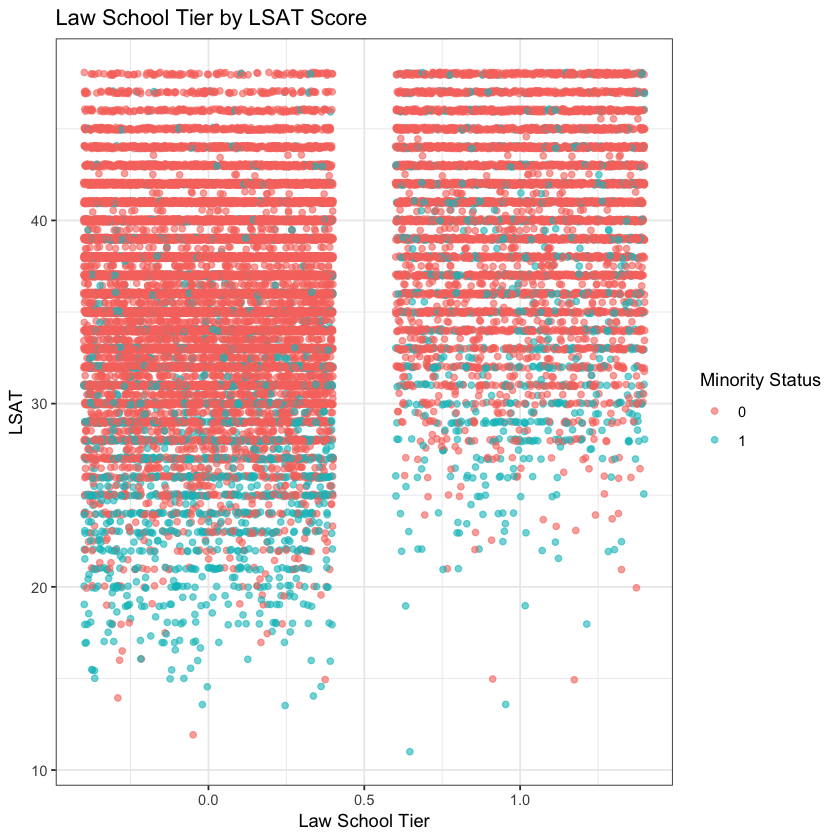

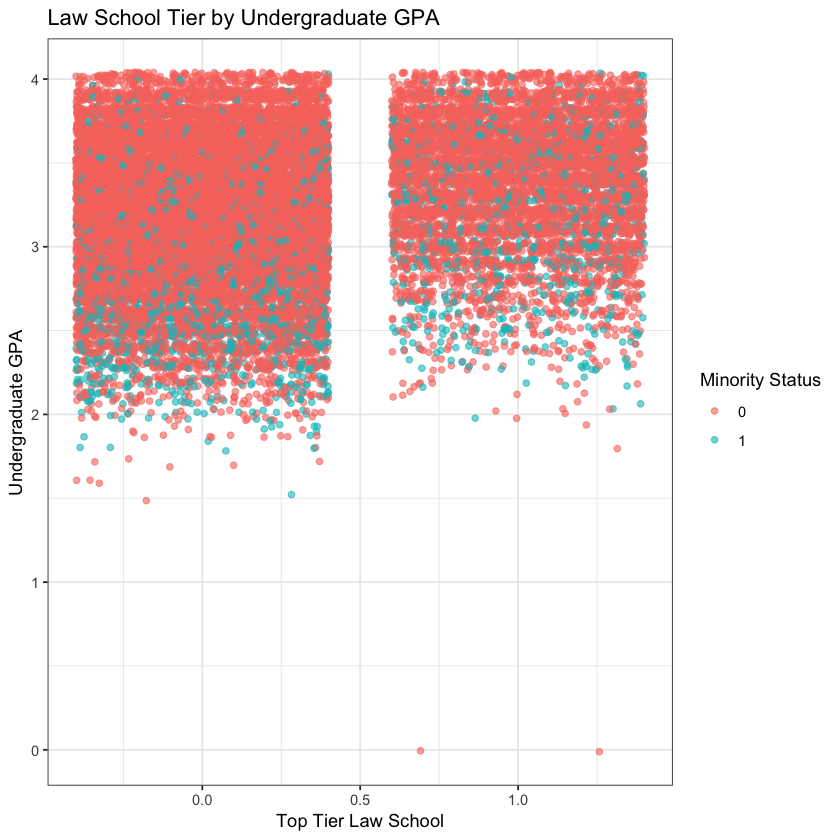

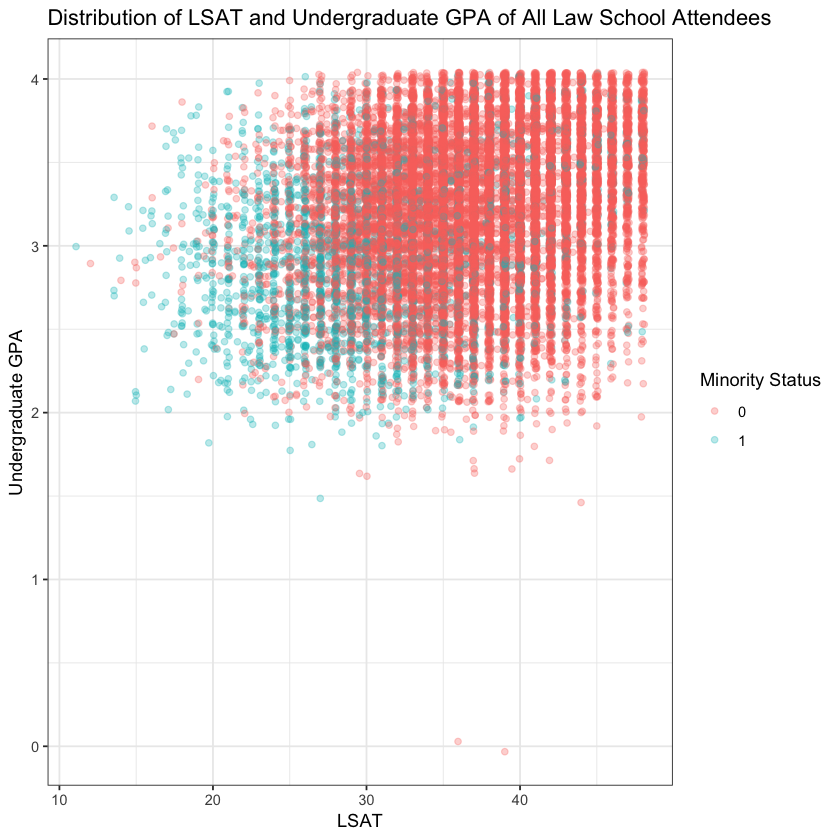

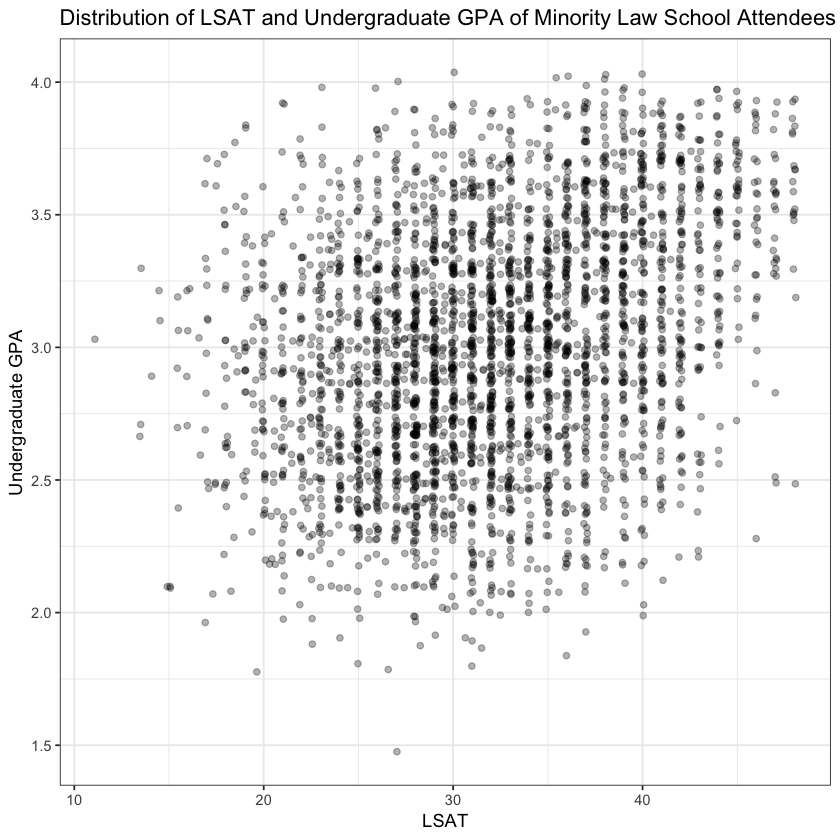

In [2]:
#WRITE CODE HERE

#START Solution
#Law school tier by LSAT
TIER_LSAT <- ggplot(data=data, aes(x=TOP_TIER, y=LSAT)) + 
    geom_jitter(aes(color=factor(MINORITY)), alpha=.6, width=.4) +
    scale_color_discrete(name = "Minority Status") +
    xlab("Law School Tier") +
    ylab("LSAT") +
    ggtitle("Law School Tier by LSAT Score")
TIER_LSAT

#Law school tier by UGPA
TIER_UGPA <- ggplot(data=data, aes(x=TOP_TIER, y=UGPA)) + 
    geom_jitter(aes(color=factor(MINORITY)), alpha=.6, width=.4) +
    scale_color_discrete(name = "Minority Status") +
    xlab("Top Tier Law School") +
    ylab("Undergraduate GPA")+
    ggtitle("Law School Tier by Undergraduate GPA")
TIER_UGPA

#LSAT and UGPA distribution for all applicants
LSAT_UGPA <- ggplot(data=data, aes(x=LSAT, y=UGPA)) + 
    geom_jitter(aes(color=factor(MINORITY)), alpha=.3, width=.1) +
    scale_color_discrete(name = "Minority Status") +
    xlab("LSAT") +
    ylab("Undergraduate GPA")+
    ggtitle("Distribution of LSAT and Undergraduate GPA of All Law School Attendees")
LSAT_UGPA

#LSAT and UGPA distribution for minority applicants
LSAT_UGPA_minority <- ggplot(data=subset(data, MINORITY==1), aes(x=LSAT, y=UGPA)) + 
    geom_jitter( alpha=.3, width=.1) +
    xlab("LSAT") +
    ylab("Undergraduate GPA") +
    ggtitle("Distribution of LSAT and Undergraduate GPA of Minority Law School Attendees")
LSAT_UGPA_minority
#END Solution

#### Excercise 2: Difference in Mean Table:

Create a difference in means table comparing white and minority applicants across LSAT, UGPA, and Income Quintile.

In [3]:
# WRITE CODE HERE

# START solution
minority_data <- subset(data, data$MINORITY==1)
white_data <- subset(data, data$MINORITY==0)
white_mean <- round(c(mean(white_data$LSAT),mean(white_data$UGPA),mean(white_data$FAM_INC)),3)
white_SE <- round(c(sd(white_data$LSAT),sd(white_data$UGPA),sd(white_data$FAM_INC)),3)

minority_mean <- round(c(mean(minority_data$LSAT),mean(minority_data$UGPA),mean(minority_data$FAM_INC)),3)
minority_SE <- round(c(sd(minority_data$LSAT),sd(minority_data$UGPA),sd(minority_data$FAM_INC)),3)

diff_in_mean <- white_mean-minority_mean
dif_table <- cbind(c("LSAT","UGPA","Family Income Quintile"),white_mean, white_SE,  minority_mean, minority_SE, diff_in_mean)
colnames(dif_table) <- c("","Whites","Whites SD","Minorities","Minorities SD","Difference in Means")
dif_table
# END solution

,Whites,Whites SD,Minorities,Minorities SD,Difference in Means
LSAT,37.243,5.077,32.021,6.806,5.222
UGPA,3.255,0.404,3.014,0.453,0.241
Family Income Quintile,3.483,0.843,3.058,0.978,0.425


### Predicting Bar Passage

We would like to predict whether individual law students will pass the bar exam. We will then use this model to simulate an admissions cycle where the students predicted as being the most likely to pass the bar are admitted into the higherest tier law schools. We will create our predictive model using a gradient boosted decision tree. 

Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning me

gbm(formula = PASS_BAR ~ LSAT + UGPA + MINORITY + FAM_INC_2 + 
    FAM_INC_3 + FAM_INC_4 + FAM_INC_5, distribution = "gaussian", 
    data = train.conditioned, n.trees = 2000, interaction.depth = 5, 
    shrinkage = 0.005, cv.folds = 10)
A gradient boosted model with gaussian loss function.
2000 iterations were performed.
The best cross-validation iteration was 467.
There were 7 predictors of which 7 had non-zero influence.


,var,rel.inf
LSAT,LSAT,56.85
UGPA,UGPA,26.05
MINORITY,MINORITY,4.79
FAM_INC_4,FAM_INC_4,3.83
FAM_INC_3,FAM_INC_3,3.38
FAM_INC_2,FAM_INC_2,3.34
FAM_INC_5,FAM_INC_5,1.77


,SplitVar,SplitCodePred,LeftNode,RightNode,MissingNode,ErrorReduction,Weight,Prediction
0,0,3.32e+01,1,11,15,10.162,2636,-1.44e-05
1,0,2.52e+01,2,3,10,2.389,340,-8.21e-04
2,-1,-2.41e-03,-1,-1,-1,0.000,22,-2.41e-03
3,1,2.65e+00,4,5,9,1.118,318,-7.11e-04
4,-1,-1.65e-03,-1,-1,-1,0.000,29,-1.65e-03
5,1,3.75e+00,6,7,8,0.901,289,-6.17e-04
6,-1,-6.99e-04,-1,-1,-1,0.000,266,-6.99e-04
7,-1,3.32e-04,-1,-1,-1,0.000,23,3.32e-04
8,-1,-6.17e-04,-1,-1,-1,0.000,289,-6.17e-04
9,-1,-7.11e-04,-1,-1,-1,0.000,318,-7.11e-04


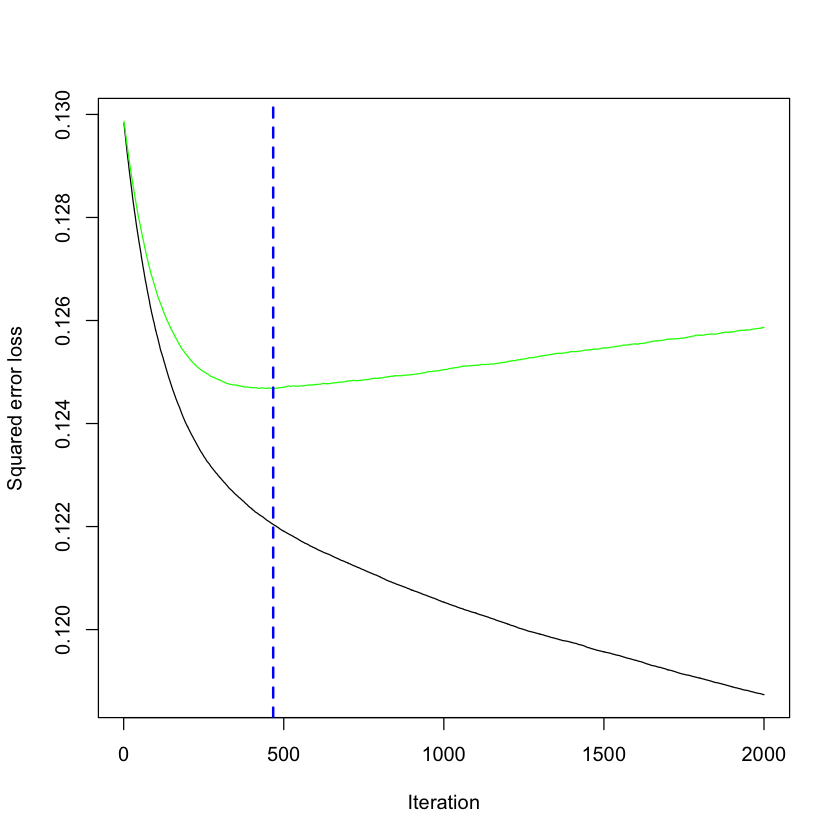

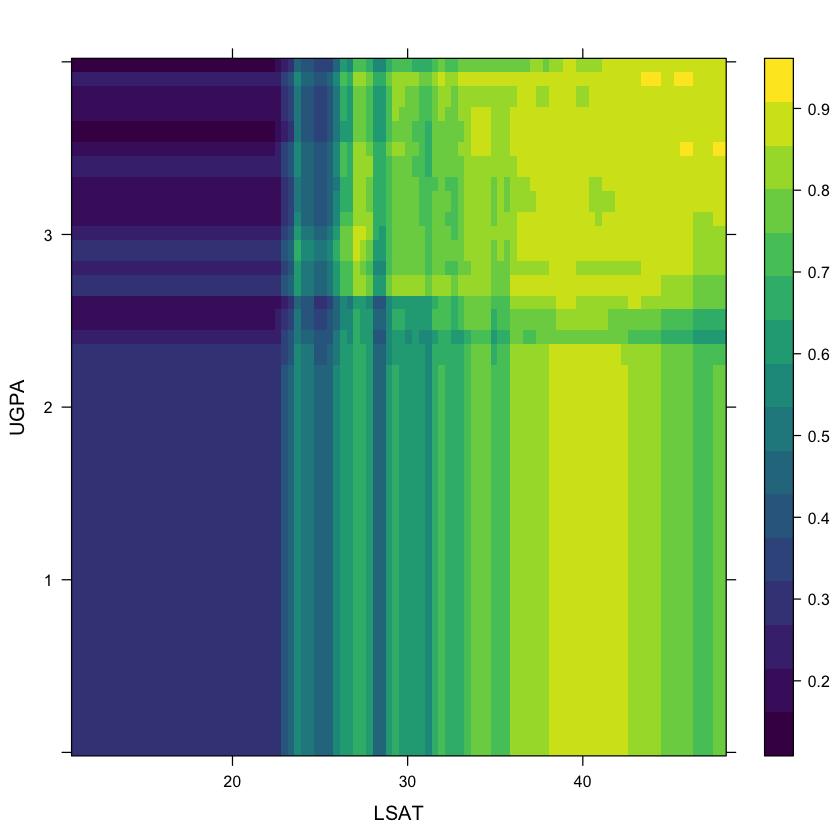

In [4]:
set.seed(12346)

'%!in%' <- function(x,y)!('%in%'(x,y))
count <- nrow(data)
train_index <- sample(1:count, count*.8, replace=FALSE)
train <- data[data$ID %in% train_index,]
test <- data[data$ID %!in% train_index,]

train.conditioned <- subset(train, train$TOP_TIER==1)

gbm_train <- gbm(PASS_BAR ~ LSAT + UGPA + MINORITY + 
             FAM_INC_2 + FAM_INC_3 + FAM_INC_4 + FAM_INC_5, data=train.conditioned,
             distribution = "gaussian", n.trees = 2000,
             shrinkage = 0.005, interaction.depth = 5, cv.folds=10)
print(gbm_train)

#Provide summary information about gradient boosted tree model
summary(gbm_train, plotit = FALSE)
pretty.gbm.tree(gbm_train, i.tree = 1)
plot(gbm_train, i.var = c("LSAT","UGPA"))

### Simulating Law School Admissions

We now will use this model to simulate law school admissions on the testing set. In our simulated admissions cycle the top tier law schools will simply accept the same number ($n$) of students as they did in actuality, but will instead simply accept the $n$ students that are the most likely to pass the bar according to our model without considering any other factors. 

#### Exercise 3: Simulate Law School Admissions Based on Predicted Bar Passage
Use the model to predict the likelihood each individual in the test set will pass the bar. Then select the $n$ students with the highest predicted likelihood of passing the bar to be selected into the top tier law schools. These students will be the admitted students in the simulation. 

Also to illistrate the results of the simulated admissions create two plots:
* graph UGPA by LSAT for students who are admitted to a top tier school
* graph UGPA by LSAT for students who are not admitted to a top tier school

Using 467 trees...
Using 467 trees...


Warning message:
“Removed 17 rows containing missing values (geom_point).”

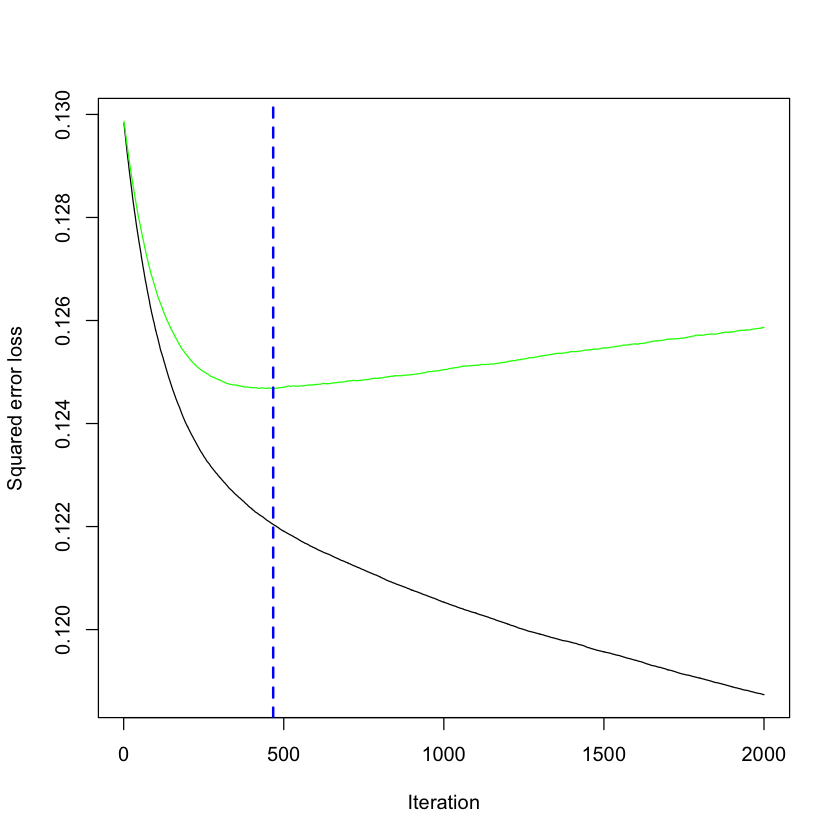

Warning message:
“Removed 1 rows containing missing values (geom_point).”

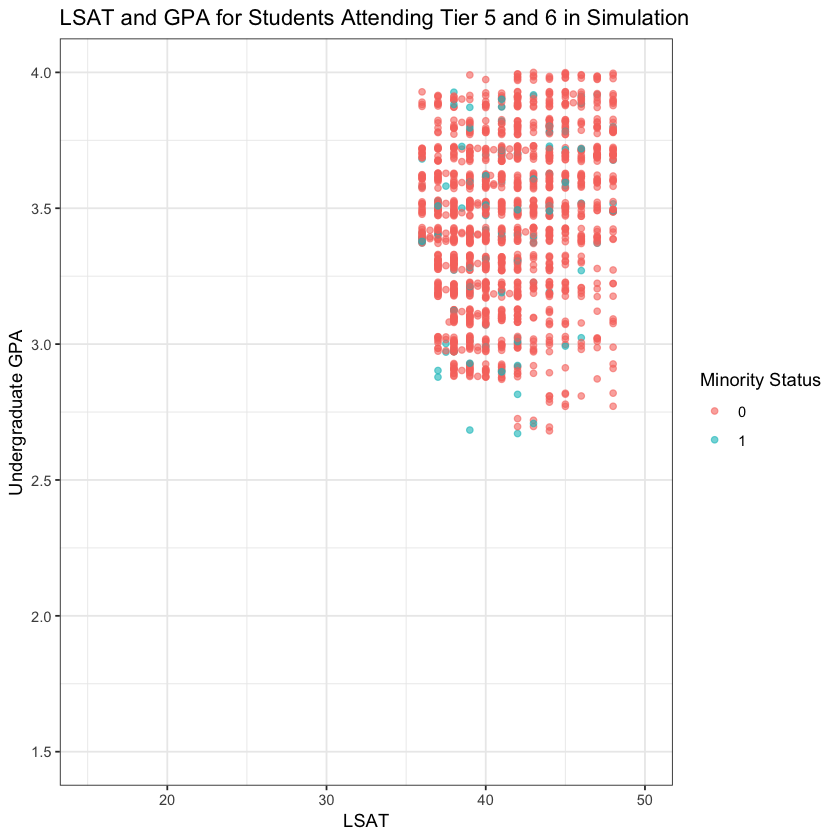

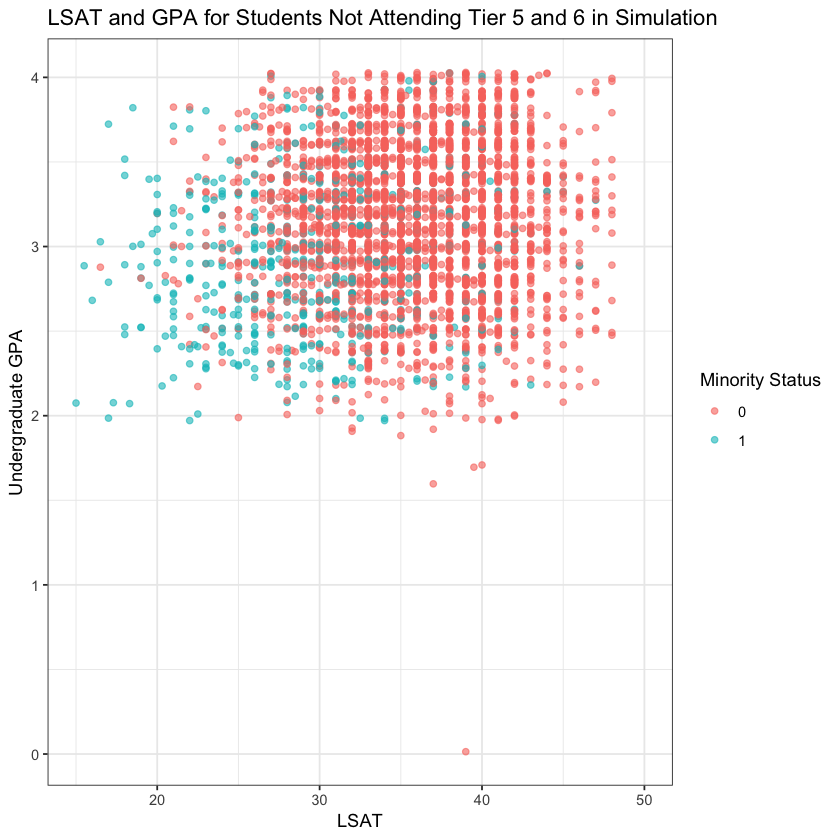

In [6]:
# WRITE CODE HERE

# START solution
#Simulate law school admissions based on predicted bar passage
train$pred <- predict(gbm_train, train)
test$pred <- predict(gbm_train, test)

select_count <- nrow(subset(test, TOP_TIER==1))
reject_count <- nrow(test)-select_count

selected <- top_n(test, select_count, pred)  
rejected <- top_n(test, -reject_count, pred)  

#Graphically present results of simulated admissions
LSAT_UGPA_selected <- ggplot(data=selected, aes(x=LSAT, y=UGPA)) + 
    geom_jitter(aes(color=factor(MINORITY)), alpha=.6, height=.03, width=0) +
    scale_color_discrete(name = "Minority Status") +
    xlab("LSAT") +
    ylab("Undergraduate GPA") +
    ggtitle("LSAT and GPA for Students Attending Tier 5 and 6 in Simulation") +
    ylim(c(1.5,4)) + 
    xlim(c(15,50))
LSAT_UGPA_selected

LSAT_UGPA_rejected <- ggplot(data=rejected, aes(x=LSAT, y=UGPA)) + 
    geom_jitter(aes(color=factor(MINORITY)), alpha=.6, height=.03, width=0) +
    scale_color_discrete(name = "Minority Status") +
    xlab("LSAT") +
    ylab("Undergraduate GPA") +
    ggtitle("LSAT and GPA for Students Not Attending Tier 5 and 6 in Simulation") +
    xlim(c(15,50))
LSAT_UGPA_rejected
#END Solution

#### Excercise 4: Crating ROC and Calibration Plots

We will create two additional plots to examine the sensitivity and specificity of the model. These plots also illistrate whether the model is prone to false predictions. 

First make an ROC plot, which graphs the true postive rate versus the false positive rate. Each point on the ROC plot shows the sensitivty/specificity of a particular cutoff point for the model. We can also use the area under the ROC cure (AUC) as a measure of the model's overall performance. 

Second, create a calibration plot. The calibration plot shows the predicted versus the actual result for law school applicants for both above and below the cut point for admission to a top tier school.

[1] "Area Under the Curve:"


[1] 0.642

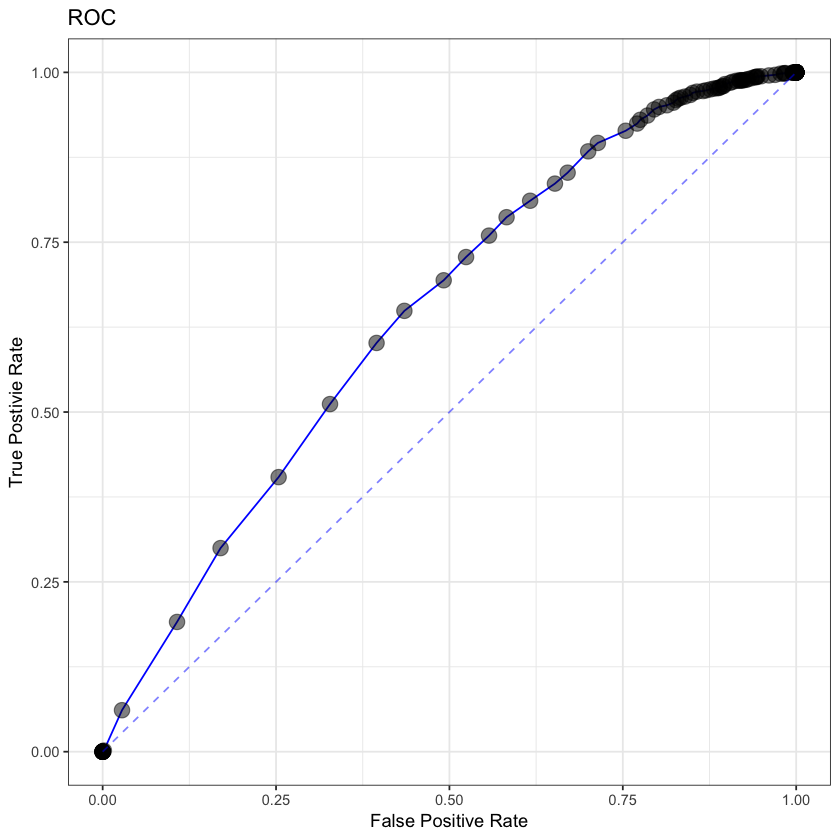

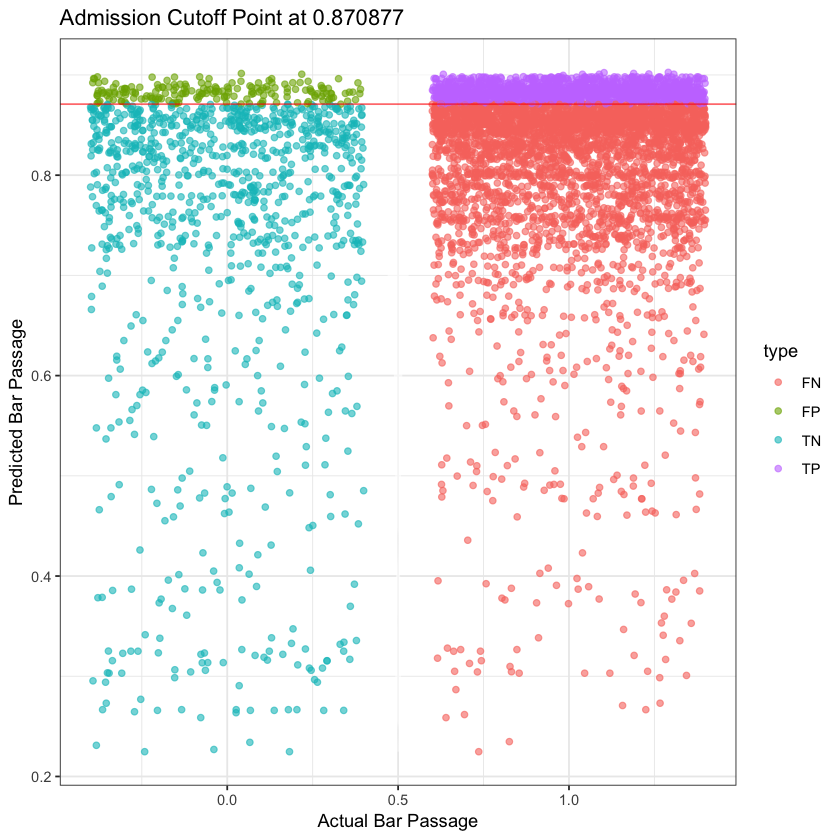

In [7]:
# WRITE CODE HERE

# START solution
# ROC Plot
plot_df <- data_frame("actual" = test$PASS_BAR, "pred" = test$pred)

calculate_roc <- function(df, n=101) {
  tpr <- function(df, threshold) {
    sum(df$pred >= threshold & df$actual == 1) / sum(df$actual == 1)
  }
  
  fpr <- function(df, threshold) {
    sum(df$pred >= threshold & df$actual == 0) / sum(df$actual == 0)
  }
    
  roc <- data.frame(threshold = seq(0,1,length.out=n), tpr=NA, fpr=NA)
  roc$tpr <- sapply(roc$threshold, function(th) tpr(df, th))
  roc$fpr <- sapply(roc$threshold, function(th) fpr(df, th))
  
  return(roc)
}

min_pred <- min(selected$pred)                 
                    
roc <- calculate_roc(plot_df)                
cutoff <- min_pred             
hline_val <- roc[roc$threshold==cutoff,]$tpr                    
vline_val <- roc[roc$threshold==cutoff,]$fpr  
                    
roc_plot <- ggplot(roc, aes(fpr,tpr)) + 
    geom_line(color=rgb(0,0,1)) +
    geom_point(size=4, alpha=0.5) +
    ggtitle("ROC") + xlab("False Positive Rate") + ylab("True Postivie Rate") +
    geom_line(aes(threshold,threshold), color=rgb(0,0,1,alpha=0.5),linetype="dashed") +
    geom_hline(yintercept=hline_val, alpha=0.5, linetype="dashed") +
    geom_vline(xintercept=vline_val, alpha=0.5, linetype="dashed")
roc_plot
                    
AUC <- -sum(diff(roc$fpr)*rollmean(roc$tpr,2))
print("Area Under the Curve:")
AUC
                    
# Calibration Plot
calibration_plot <- function(df, threshold) {
  v <- rep(NA, nrow(df))
  v <- ifelse(df$pred >= threshold & df$actual == 1, "TP", v)
  v <- ifelse(df$pred >= threshold & df$actual == 0, "FP", v)
  v <- ifelse(df$pred < threshold & df$actual == 1, "FN", v)
  v <- ifelse(df$pred < threshold & df$actual == 0, "TN", v)
    
  df$pred_type <- v
    
  ggplot(data=df, aes(x=actual, y=pred)) + 
    geom_violin(fill=rgb(1,1,1,alpha=0.6), color=NA) + 
    geom_jitter(aes(color=pred_type), alpha=0.6) +
    geom_hline(yintercept=threshold, color="red", alpha=0.6) +
    scale_color_discrete(name = "type") +
    xlab("Actual Bar Passage") + ylab("Predicted Bar Passage") +
    labs(title=sprintf("Admission Cutoff Point at %f", threshold))
}

calibration_plot(plot_df, min_pred)
#END Solution

### Evaluating Disparate Impact

Having simulated admissions to law schools, we now want to check how the number of minority students who would be admitted to top law schools if our model was used compares to how many minority students were actually admitted. 

#### Exercise 5: Comparing Admissions Rates
* Calculate the number of minority students admitted to top tier schools in the actual data and compare that to the number of minority students so admitted in the simulated data. This will illustrate how the simulated results compare to actuanl law school admissions for the period in question, but doesn't nessecarily tell us how to interpret any variation. 
* Next, calculate the percent of law school applicants who are minorities. Then calculate what percentage of admitted students are minorities for both the simulated and actual admissions. 
* Create a table to store the these results for the model, the actual results, and the corresponding numbers for the full population of law school attendees. Include the following information in the table
    * Model
    * Number of Minority Students Admitted
    * Percentage of Minority Students Admitted
* For the full population include the total number of minoirty law school admits and the overall percentage of minorties among all admits. 

* If our model was used, would there be a valid disparate action claim for any applicants who are rejected from top tier schools?

In [9]:
# WRITE CODE HERE

# START solution
actual_selected <- subset(test, TOP_TIER==1)
selected_minority <- subset(selected, MINORITY ==1)
selected_white <- subset(selected, MINORITY == 0)
rejected_minority <- subset(rejected, MINORITY ==1)
rejected_white <- subset(rejected, MINORITY ==0)
actual_minority <- subset(actual_selected, MINORITY ==1)
actual_white <- subset(actual_selected, MINORITY ==0)

model <- c("Full Applicant Population","Actual Top Tier Admissions","Gradient Boosted Tree Simulated Top Tier Admissions")

#Comparing simulated admissions to actual admissions
gbm_minority_count <- nrow(selected_minority)
actual_minority_count <- nrow(actual_minority)
minority_students_admitted <- c(sum(test$MINORITY==1),actual_minority_count, gbm_minority_count)


#Comparing parity of admissions decisions by race
percent_applicant_minority <- (nrow(selected_minority) + nrow(rejected_minority)) / nrow(test)
gbm_percent_minorty <- nrow(selected_minority) / nrow(test)
actual_percent_minority <- nrow(actual_minority) / nrow(test)

percent_minority <- round(c(percent_applicant_minority, actual_percent_minority, gbm_percent_minorty),3)

#Putting all the data together into a table
results <- data.frame(model, minority_students_admitted, percent_minority)
colnames(results) <- c("Model","Minority students admitted","Percent of minroty students admitted")
results

#END Solution

Model,Minority students admitted,Percent of minroty students admitted
Full Applicant Population,752,0.124
Actual Top Tier Admissions,242,0.040
Gradient Boosted Tree Simulated Top Tier Admissions,105,0.017


#### Excercise 6: Evaluate this Model as a Policy Proposal

Consider if an admissions office came to you with the proposal of using this model for dertermining which law students that school would admit. How would you evaluate the model and what would you recomemnd to the admissions office? 

### Modeling Bar Passage Without Race or Gender

#### Exercise 7: Creating a Model for Bar Passage Without Race and Gender

One aspect of the above model that we might be concerned about is the fact that it specifically includes suspect class information, namely race and gender. But does leaving out race and gender impact the results of simulated law school admissions or even make the results potentially more biased?

Consider that if race and gender are left out, the model has less information to train on and we would expect it therefore, all else being equal, to be less accurate than a model with that information. And while the model will no longer explicitly categorize based on race and gender, racial and gender differences may still get picked up by the model through other correlated variables. 

Based on the model above, create a new gradient boosted tree that leaves out the applicants' race and gender. Then simulate law school admissions by selecting the top $n$ students to be admitted to top tier law schools. 

Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning message in predict.gbm(model, newdata = my.data, n.trees = best.iter.cv):
“NAs introduced by coercion”Warning me

Using 443 trees...


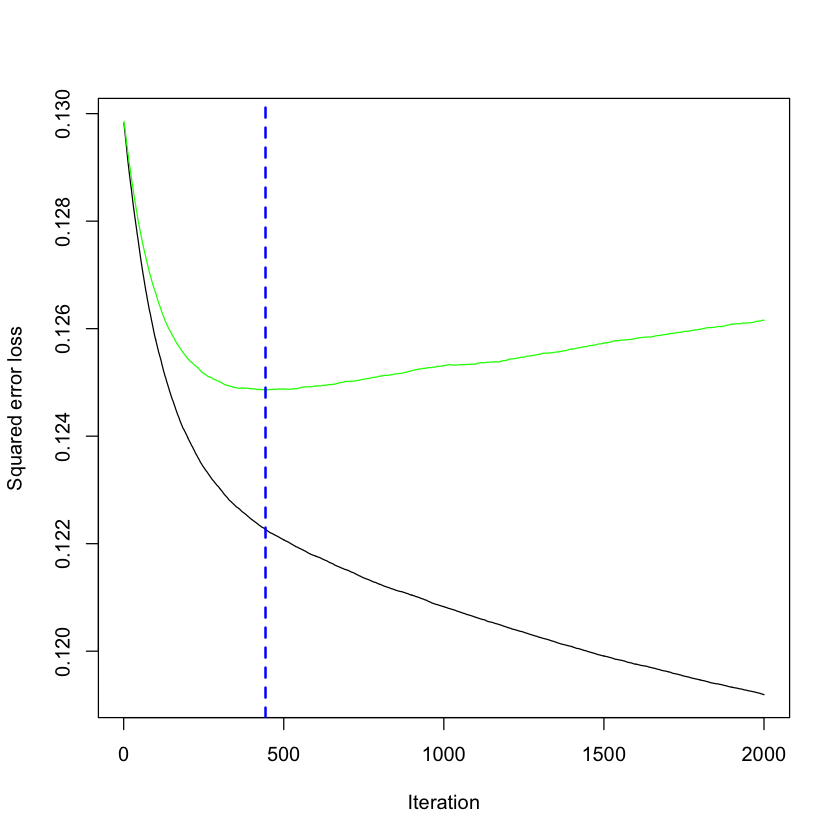

In [10]:
# WRITE CODE HERE

#START Solution
set.seed(12346)
gbm_train_2 <- gbm(PASS_BAR ~ LSAT + UGPA + 
             FAM_INC_2 + FAM_INC_3 + FAM_INC_4 + FAM_INC_5, data=train.conditioned,
             distribution = "gaussian", n.trees = 2000,
             shrinkage = 0.005, interaction.depth = 5, cv.folds=10)


test$pred_2 <- predict(gbm_train_2, test)

selected_2 <- top_n(test, select_count, pred_2)  
rejected_2 <- top_n(test, -reject_count, pred_2)
#END Solution

#### Exercise 8: Assess the racial distribution of students admitted under the new model
Use the same measures as above to assess the racial impact of this new model and whether there is evidence of algorithmic bias. Add the results to the results table you created initially for the original model. 

How does this test compare to the previous one? Is your assessment different?

In [14]:
# WRITE CODE HERE

# START solution
selected_minority_2 <- subset(selected_2, MINORITY==1)
rejected_minority_2 <- subset(rejected_2, MINORITY==1)
selected_white_2 <-subset(selected_2, MINORITY==0)

gbm_no_race_gender_minority_count <- nrow(selected_minority_2)
gbm_no_race_gender_percent_minority <- nrow(selected_minority_2) / nrow(test)

no_race_gender <- data_frame(A="GBTree Without Race or Gender", B=gbm_no_race_gender_minority_count, C=round(gbm_no_race_gender_percent_minority,3))
colnames(no_race_gender) <- colnames(results)
results <- rbind(results, no_race_gender)
results

#END Solution

Model,Minority students admitted,Percent of minroty students admitted
Full Applicant Population,752,0.124
Actual Top Tier Admissions,242,0.040
Gradient Boosted Tree Simulated Top Tier Admissions,105,0.017
GBTree Without Race or Gender,90,0.015
Ten Percent Plan,111,0.018
GBTree Without Race or Gender,90,0.015


### Testing an Alternative Admission Process: A Top 10% Plan

Texas adopted a top ten percent admission plan in 1997 for undergraduate admissions in the state. Anti-affirmative action advocates subsequently challenged the top-ten percent plan in the high profile affirmative action lawsuit *Fisher v. Texas* which was the subject of Supreme Court decisions in 2013 and 2016. 

A top ten percent admissions plan works by automatically admitting all students with a GPA in the top 10% of their graduating class and then admitting students for remaining spots based on holistic review. For our purposes we will simulate this by admitting all students with a GPA within the top 10% of all law school applicants and then using the bar passage rate model to admit students for the remaining spaces in the class. Notice, however, that this approximation fails to capture how a student's GPA ranks within their own high schools, which is central for how the top ten percent plan actually works. That is in Texas's actual policy, students are only compared to the other students within the same school. 

#### Exercise 9: Simulate a top ten percent plan for law school admissions
Simulate an admissions cycle for top tier law schools assuming a centralized top ten percent plan. First select all applicants with a UGPA in the top ten percent of applicants and then round out the class with students who have the highest predicted bar passage scores.


In [15]:
#WRITE CODE HERE

#BEGIN SOLUTION
ten_percent_count <- round(nrow(test)*.1)
selected_gpa <- top_n(test, ten_percent_count, UGPA)  
unselected_gpa <- test[!(test$ID %in% selected_gpa$ID),]

remainder_select_count <- select_count - nrow(selected_gpa)
selected_remainder <-  top_n(unselected_gpa, remainder_select_count, pred)

selected_topten <- rbind(selected_remainder, selected_gpa)
rejected_topten <- test[!(test$ID %in% selected_topten$ID),]

# Note, this algorithm slightly overadmits students because it admits additional students 
# in the case of prediction scores

#END Solution

#### Exercise 10: Assess the racial distribution of students admitted under the simulated top ten percent plan

Repeat the analyses for racial impact and algorithmic bias as above but using the top-ten percent plan simulation. Add the results to your results table. 

In [16]:
#WRITE CODE HERE

#BEGIN SOLUTION
selected_minority_topten <- subset(selected_topten, MINORITY == 1)
rejected_nminority_topten <- subset(rejected_topten, MINORITY == 1)
selected_white_topten <- subset(selected_topten, MINORITY == 0)

#Comparing simulated admissions to actual admissions
topten_minority_count <- nrow(selected_minority_topten)

#Comparing parity of admissions decisions by race
topten_percent_minorty <- nrow(selected_minority_topten) / nrow(test)

ten_percent <- data_frame(A="Ten Percent Plan", B=topten_minority_count, C=round(topten_percent_minorty,3))
colnames(ten_percent) <- colnames(results)
results <- rbind(results, ten_percent)
results
#END SOLUTION

Model,Minority students admitted,Percent of minroty students admitted
Full Applicant Population,752,0.124
Actual Top Tier Admissions,242,0.040
Gradient Boosted Tree Simulated Top Tier Admissions,105,0.017
GBTree Without Race or Gender,90,0.015
Ten Percent Plan,111,0.018
GBTree Without Race or Gender,90,0.015
Ten Percent Plan,111,0.018


### Discussion Questions

One way to characterize the use of bar passage information is as an attempt to reduce the importance of the LSAT in determining law school admissions. Does using bar passage data fulfill the goal of reducing emphasis on the LSAT?

Consider what some of the potential problems with this data set are. What factors are not represented in the data that might be relevant for predicting outcomes on the bar exam? For success as an attorney? Are their any concerns about state bar passage as an outcome measure? What factors might drive the differences between the different models?  

How well do these models mimic the procedure of the actual admissions process? How does the performance of actual admissions officers compare to the models we have here and to the extent there are differences in outcomes, what factors might drive those differences? 

Are there important differences between the populations of interest that may influence the model in undesirable ways? Consider whether minority students are more likely to practice in jurisdictions with lower bar passage rates (e.g., NY or CA)? Could stereotype threat explain difference in academic performance between white and minority students who are otherwise similar?